In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
from transformers import BertModel

#GPU 사용 시
device = torch.device("cuda:0")

In [14]:
def get_font_family():
    """
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    """
    import platform
    system_name = platform.system()

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        # Linux(colab)
        !apt-get install fonts-nanum -qq  > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont
        
        font_family = "NanumBarunGothic"
    return font_family


# style 설정은 꼭 폰트설정 위에서 합니다.
# style 에 폰트 설정이 들어있으면 한글폰트가 초기화 되어 한글이 깨집니다.
plt.style.use("seaborn")
# 폰트설정
plt.rc("font", family=get_font_family())

# 마이너스폰트 설정
plt.rc("axes", unicode_minus=False)

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

In [15]:
raw_train = pd.read_csv("df_final_training2.csv")
raw_test = pd.read_csv("df_final_validation2.csv")

In [16]:
raw_train.shape, raw_test.shape

((40827, 13), (5122, 13))

In [17]:
raw_train.head(3)

,persona-id,emotion-id,type,emotion,situation,age_id,sex_id,HS01,SS01,HS02,SS02,HS03,SS03
0,Pro_03719,S05_D02_E68,E68,신이 난,"['S05', 'D02']",A02,G01,아내가 드디어 출산하게 되어서 정말 신이 나.,아내분이 출산을 하시는군요. 정말 축하드려요.,아 지금 정말 신이 나.,잘 된 일이네요.,아기가 점점 클게 벌써 기대가 되네. 내가 많이 놀아줘야지.,좋은 아빠가 되실 거 같아요. 진심으로 축하드려요.
1,Pro_10583,S11_D01_E32,E32,스트레스 받는,"['S11', 'D01']",A02,G01,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,약 종류가 많아 번거로우시겠어요.,건강할 때 관리 좀 잘할걸 하는 생각이 들더라고.,현재 상황에서 변화를 주기 위해 어떻게 하면 될까요?,약을 잘 챙겨 먹고 나을 수 있도록 노력해야지.,약을 잘 챙겨 먹어 건강해지시길 바랄게요.
2,Pro_01781,S02_D02_E50,E50,당황,"['S02', 'D02']",A02,G01,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,고등학교 수업이 중학교 때와는 다르게 갑자기 어려워서 당황스러우시군요.,아직 학기 초인데 내가 수업에 잘 따라갈 수 있을지 걱정돼.,이 상황에서 할 수 있는 게 어떤 것이 있을까요?,중학교 수업을 들을 때보다 훨씬 더 열심히 할 거야.,수업을 어떤 방식으로 열심히 듣는게 좋을까요?


In [18]:
raw_test.head(3)

,persona-id,emotion-id,type,emotion,situation,age_id,sex_id,HS01,SS01,HS02,SS02,HS03,SS03
0,Pro_05342,S06_D02_E11,E11,툴툴대는,"['S06', 'D02']",A02,G02,요즘 부모님과 많이 부딪혀.,어떤 일로 부딪히시나요?,난 하고 싶은 일이 있는데 부모님은 안정적인 일만 하라고 하셔. 내 마음대로 하지도...,부모님과의 충돌로 힘드시겠군요.,응. 그래도 난 내가 하고 싶은 일을 위해 노력할 거야.,자신이 하고 싶은 일을 목표로 하기로 하셨군요.
1,Pro_00073,S01_D02_E22,E22,비통한,"['S01', 'D02']",A02,G02,엄마가 결국 집을 나갔어. 너무 너무 슬퍼.,어머니께서 집을 나가셨다니 정말 슬프셨겠어요. 좀 더 자세히 얘기해주시겠어요?,엄마도 엄마만의 인생이 있을 테니 가지 말라고 할 수가 없었어. 그래서 더 마음이 ...,정말 많이 답답하셨겠어요. 어떻게 하는 게 기분이 좀 풀릴까요?,일단 좀 자야겠어.,일단 휴식을 가질 생각이시군요.
2,Pro_00329,S03_D02_E38,E38,조심스러운,"['S03', 'D02']",A02,G02,학교에서 한 친구를 괴롭히는 무리에게 그만하라고 했어.,용기 있는 행동을 하셨네요. 마음이 어떠셨나요?,그런데 말을 하고 난 후 나도 괴롭힐까 봐 불안했어.,그랬군요. 지금 기분에서 벗어나기 위해 할 수 있는 일에는 무엇이 있을까요?,나는 옳은 일을 한 거라고 생각해. 나까지 괴롭힌다면 신고할 거야.,지금의 상황이 나의 방식으로써 잘 해결될 수 있기를 바라요.


In [19]:
def transform_rawdataset(raw_df):
    df = raw_df[["type","HS01","HS02","HS03"]]
    df = df.fillna('')
    return df

df_train_raw = transform_rawdataset(raw_train)
df_test_raw = transform_rawdataset(raw_test)

In [20]:
emo = ["분노","슬픔","불안","상처","당황","기쁨"]
emo_label = [0,1,2,3,4,5]
df_train_raw["emotion"] = df_train_raw["type"]
df_test_raw["emotion"] = df_test_raw["type"]

for i in range(1,7):
    df_train_raw.loc[df_train_raw["type"].isin([f"E{j}"for j in range(10*i,20*i)]),"emotion"] = emo_label[i-1]
    df_test_raw.loc[df_test_raw["type"].isin([f"E{j}"for j in range(10*i,20*i)]),"emotion"] = emo_label[i-1]


In [21]:
def preprocessing_dataset(raw_df):
    df_hs01 = raw_df[["HS01","emotion"]]
    df_hs02 = raw_df[["HS02","emotion"]]
    df_hs03 = raw_df[["HS03","emotion"]]
    df_hs03.drop(df_hs03[df_hs03["HS03"] == ''].index,inplace=True)

    df_hs01.columns = ["content","emotion"]
    df_hs02.columns = ["content","emotion"]
    df_hs03.columns = ["content","emotion"]
    
    new_df = pd.concat([df_hs01,df_hs02,df_hs03],ignore_index=True)
    new_df['emotion_content'] = new_df['emotion'].map(lambda x: emo[x])
    
    return pd.DataFrame(new_df)

df_train = preprocessing_dataset(df_train_raw)
df_test = preprocessing_dataset(df_test_raw)

/opt/anaconda3/envs/ML/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(112666, 3) (14111, 3)


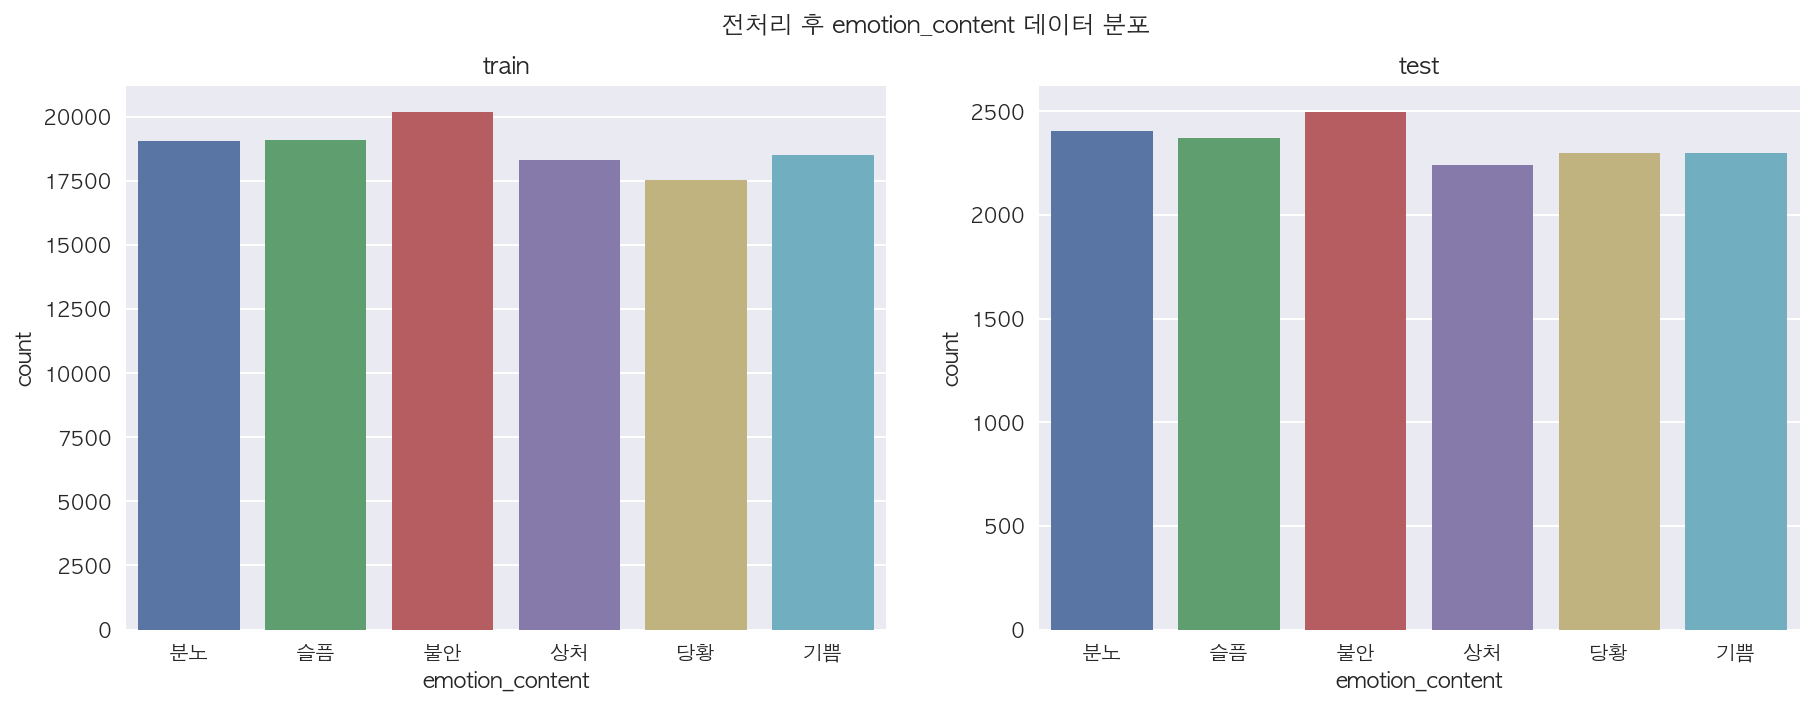

In [22]:
print(df_train.shape,df_test.shape)
# visualize "emotion_content" of df_train and df_test with 2 subplots with title of each subplot
fig, axs = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle("전처리 후 emotion_content 데이터 분포")
sns.countplot(x="emotion_content", data=df_train, ax=axs[0], order=emo)
axs[0].set_title("train")
sns.countplot(x="emotion_content", data=df_test, ax=axs[1], order=emo)
axs[1].set_title("test")
plt.show()


In [23]:
df_train.head()

,content,emotion,emotion_content
0,아내가 드디어 출산하게 되어서 정말 신이 나.,5,기쁨
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,2,불안
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,4,당황
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,5,기쁨
4,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,5,기쁨


In [24]:
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

bertmodel, vocab = get_pytorch_kobert_model()

tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer,vocab,lower=False)

using cached model. /Users/sabin/Documents/GitHub/my_relation/dataset/.cache/kobert_v1.zip
using cached model. /Users/sabin/Documents/GitHub/my_relation/dataset/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece
using cached model. /Users/sabin/Documents/GitHub/my_relation/dataset/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [28]:
df_train["content_token"] = df_train["content"].map(lambda x: tok(x))
df_test["content_token"] = df_test["content"].map(lambda x: tok(x))

df_train["token_length"] = df_train["content_token"].map(lambda x: len(x))
df_test["token_length"] = df_test["content_token"].map(lambda x: len(x))

df_train

,content,emotion,emotion_content,content_token,token_length
0,아내가 드디어 출산하게 되어서 정말 신이 나.,5,기쁨,"[▁아내, 가, ▁드, 디, 어, ▁출산, 하게, ▁되어, 서, ▁정말, ▁신, 이...",15
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,2,불안,"[▁당, 뇨, 랑, ▁합병, 증, ▁때문에, ▁먹, 어야, ▁할, ▁약, 이, ▁열...",21
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,4,당황,"[▁, 고등학교, 에, ▁올라, 오, 니, ▁중, 학교, ▁때, 보다, ▁수업, 이...",20
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,5,기쁨,"[▁재, 취, 업, 이, ▁돼, 서, ▁받게, ▁된, ▁첫, ▁, 월, 급, 으로,...",29
4,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,5,기쁨,"[▁빚, 을, ▁드, 디, 어, ▁다, ▁, 갚, 게, ▁되어, 서, ▁이제, 야,...",20
...,...,...,...,...,...
112661,최 영감에게 기분 좋은 말을 해줘야 할 것 같아.,3,상처,"[▁최, ▁영, 감, 에게, ▁기분, ▁좋은, ▁말을, ▁해, 줘야, ▁할, ▁것,...",14
112662,이대로 내가 키우게 되면 안 되니까 확실하게 해야겠어.,2,불안,"[▁이, 대로, ▁내가, ▁키우, 게, ▁되면, ▁안, ▁되, 니까, ▁확, 실, ...",17
112663,내가 다시 내 꿈을 어떻게 이룰 것인지 자세히 설명해 드려야겠어.,1,슬픔,"[▁내가, ▁다시, ▁내, ▁꿈, 을, ▁어떻게, ▁이, 룰, ▁것인지, ▁자세, ...",20
112664,운동으로 뭉친 근육을 풀어주는 것 같아. 그럼 덜 피로하겠지.,5,기쁨,"[▁운동, 으로, ▁, 뭉, 친, ▁근육, 을, ▁풀어, 주는, ▁것, ▁같아, ▁...",23


In [37]:
df_train['token_length'].value_counts().sort_index()

3       1
4       7
5      66
6     251
7     605
     ... 
65      2
68      1
71      1
75      1
94      2
Name: token_length, Length: 67, dtype: int64

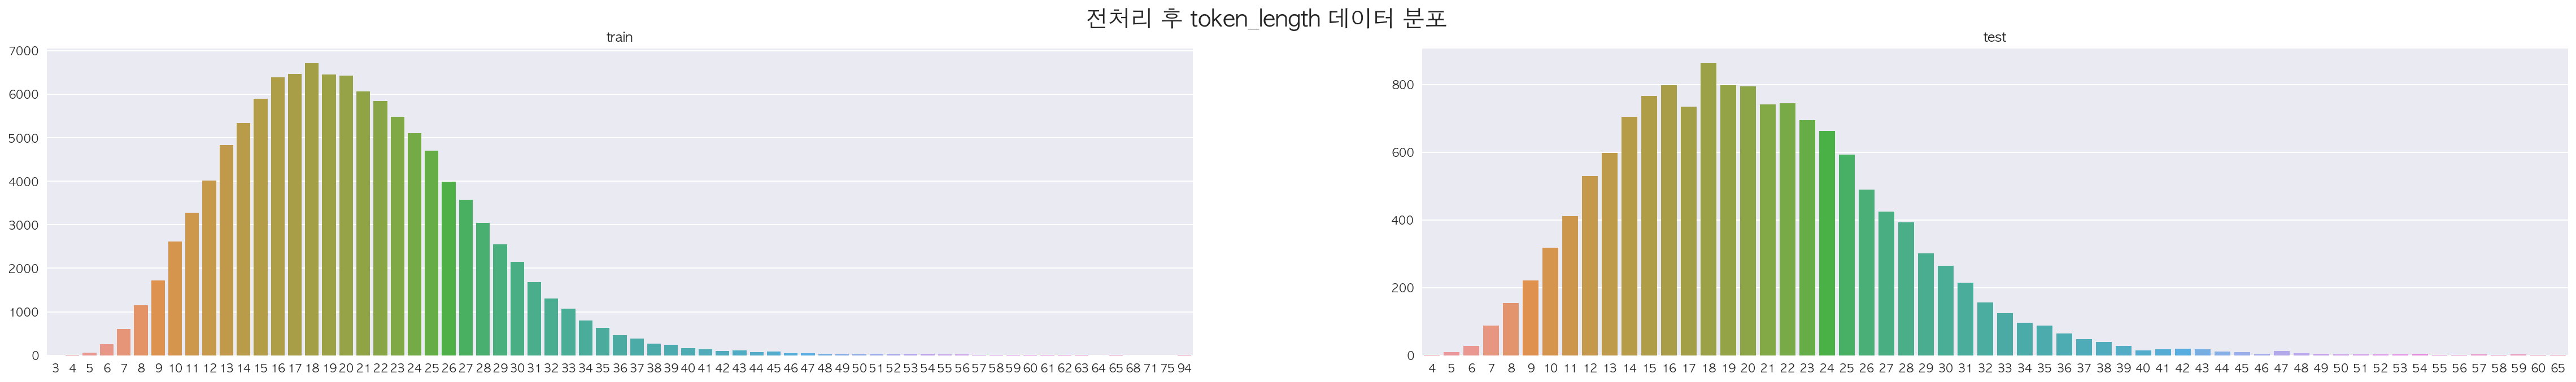

In [42]:
# visualize df_train['token_length'].value_counts().sort_index() of df_train and df_test with 2 subplots with title of each subplot

fig, axs = plt.subplots(1, 2, figsize=(40,5))
fig.suptitle("전처리 후 token_length 데이터 분포", fontsize=20)
sns.barplot(x=df_train['token_length'].value_counts().sort_index().index, y=df_train['token_length'].value_counts().sort_index().values, ax=axs[0])
axs[0].set_title("train")
sns.barplot(x=df_test['token_length'].value_counts().sort_index().index, y=df_test['token_length'].value_counts().sort_index().values, ax=axs[1])
axs[1].set_title("test")
plt.show()